# Compare trends with GIMMS-PKU

How does the GIMMS-PKU 'consolidated' product compare with our product with-regards-to the trends in vPOS and POS we indentified? 

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy.signal
import xskillscore as xs
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from matplotlib.ticker import FormatStrFormatter
from xarrayMannKendall import Mann_Kendall_test

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
pku = xr.open_dataarray(base+'/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

# merge = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
merge = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

## Match datasets

In [4]:
merge = merge.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
merge = round_coords(merge)
pku = round_coords(pku)
rain = round_coords(rain)

In [5]:
avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)

pku_mask =  ~np.isnan(pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

#combine masks
mask = (avhrr_mask & pku_mask) # & cdr_mask

In [6]:
pku = pku.sel(time=pku.time).where(mask)
merge = merge.sel(time=pku.time).where(mask)
rain = rain.sel(time=pku.time).where(mask)

merge = merge.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})

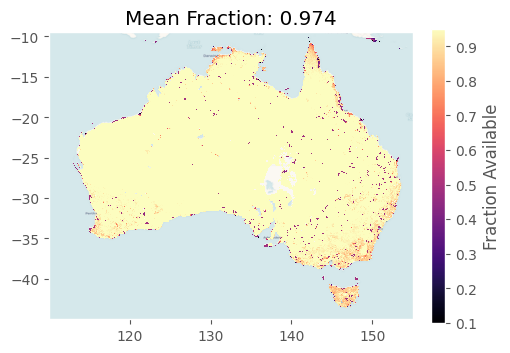

In [7]:
fraction_avail_pku = (~np.isnan(pku)).sum('time')/len(pku.time)
fraction_avail_merge = (~np.isnan(merge)).sum('time')/len(merge.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail_pku.where(fraction_avail_pku>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail_pku.where(fraction_avail_pku>0).mean().values.item(), 3)));

### Timeseries plots


#### per region

In [8]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


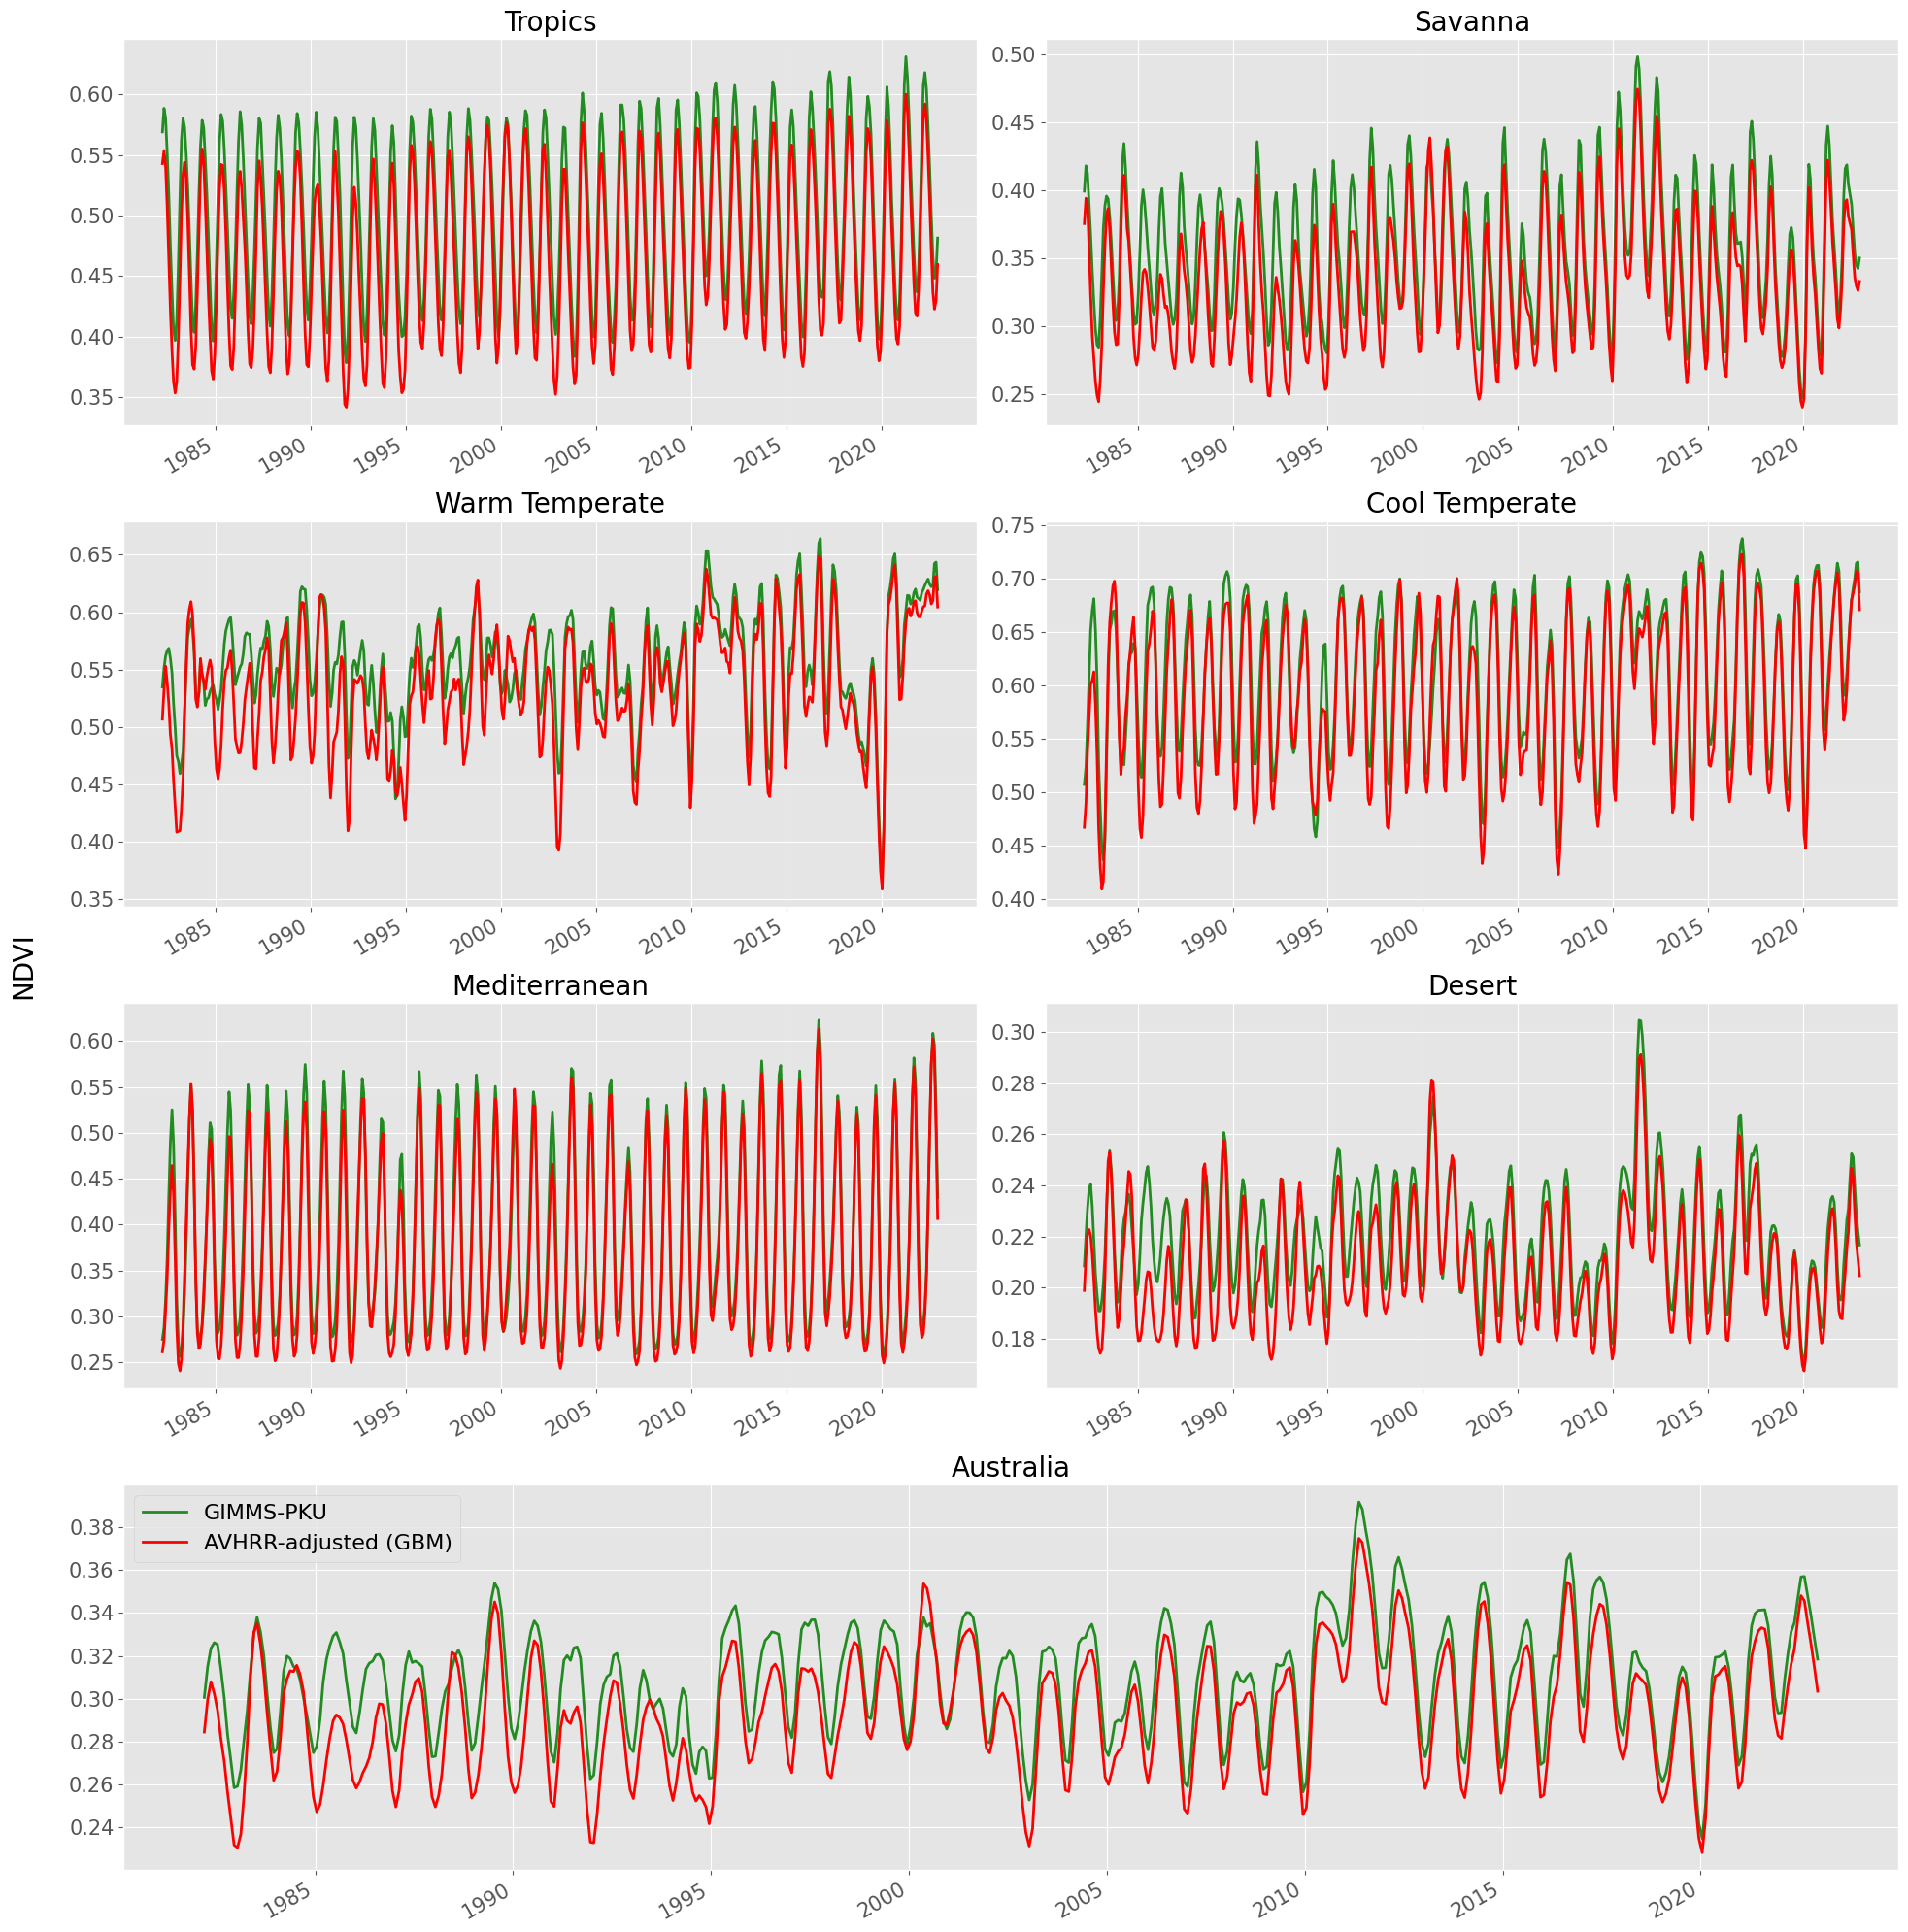

In [9]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], pku, crs=crs)
    mask = mask.rename({'latitude':'y', 'longitude':'x'})
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    pku_region = pku.where(mask)
    merge_region = merge.where(mask)

    pku_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='GIMMS-PKU', c ='forestgreen', linewidth=2)
    merge_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
pku.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='GIMMS-PKU', c ='forestgreen', linewidth=2)
merge.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_PKU_timeseries_bioregion.png',
            bbox_inches='tight', dpi=300);

## Rolling mean anomalies

In [10]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
merge_std_anom = stand_anomalies(merge)

In [25]:
roll=3

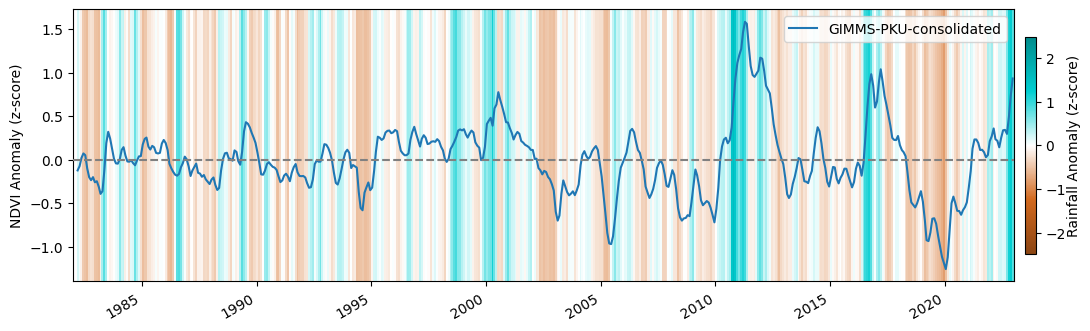

In [27]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['x','y']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()

pku_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='GIMMS-PKU-consolidated')
# syn_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Synthetic')
# merge_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AVHRR-Adj. (GBM)')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
# ax.set_ylim([-1.25, 1.25])
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compare_PKU_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)

In [ ]:
year='1989'

fig,ax = plt.subplots(1,3, figsize=(14,4), sharex=True, layout='constrained')
rain_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='RdBu', ax=ax[0], add_labels=False)
pku_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[1], add_labels=False)
merge_std_anom.sel(time=year).mean('time').plot.imshow(vmin=-2.5, vmax=2.5, cmap='BrBG', ax=ax[2], add_labels=False)

ax[0].set_title('Rainfall anomaly')
ax[1].set_title('PKU NDVI anomaly')
ax[2].set_title('AVHRR Adj (GBM) NDVI anomaly')
ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([]);

ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xticklabels([]);
ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_xticklabels([]);

## NDVI moisture sensitivity before and after MODIS era

In [100]:
# #standardized anom
# def anomalies(ds):
#     return xr.apply_ufunc(
#         lambda x, m: (x - m),
#             ds.groupby("time.month"),
#             ds.groupby("time.month").mean(),
#     )
    
# rain_anom = anomalies(rain)
# pku_anom = anomalies(pku)
# merge_std_anom = stand_anomalies(merge)

In [75]:
# ndvi_water_sensitivity = (pku.rolling(time=12, min_periods=12).mean() / rain.rolling(time=12, min_periods=12).mean())

# avhrr_era_ndvi_water_sensitivity = ndvi_water_sensitivity.sel(time=slice('1982', '2000')).mean('time')
# modis_era_ndvi_water_sensitivity = ndvi_water_sensitivity.sel(time=slice('2000', '2022')).mean('time')

# # (modis_era_ndvi_water_sensitivity - avhrr_era_ndvi_water_sensitivity).plot(robust=True)

## Residuals through time



In [ ]:
#residuals after harmonization
residual = (pku - merge).mean(['x', 'y']).drop('spatial_ref').to_dataframe(name='PKU residuals')
residual_sd = (pku - merge).std(['x', 'y']).drop('spatial_ref').to_dataframe(name='PKU residuals')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

residual.plot(ax=ax, legend=False, color='blue')
ax.fill_between(residual.index, (residual-residual_sd)['PKU residuals'],
                (residual+residual_sd)['PKU residuals'], alpha=0.15, color='blue')

ax.axhline(0.0, color='k', linestyle='--')
# ax.legend(loc='upper left')
ax.set_title('Average Residuals with GIMMS PKU')
ax.set_ylim(-0.125, 0.125)
ax.set_ylabel(model_var+" $_{GIMMSPKU}$"+ " - "+model_var+"$_{AVHRR adj.}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.axvline('1985', color='red', linestyle='--', alpha=0.5)
plt.text('1982-05',-0.1,'N7-->',rotation=0)

ax.axvline('1988-11', color='red', linestyle='--', alpha=0.5)
plt.text('1986-05',-0.1,'N9-->',rotation=0)

ax.axvline('1994', color='red', linestyle='--', alpha=0.5)
plt.text('1990-02',-0.1,'<-- N11 -->',rotation=0)

ax.axvline('2000', color='red', linestyle='--', alpha=0.5)
plt.text('1996',-0.1,'<-- N14 -->',rotation=0)

ax.axvline('2007', color='red', linestyle='--', alpha=0.5)
plt.text('2002-09',-0.1,'<-- N16 -->',rotation=0)

ax.axvline('2010', color='red', linestyle='--', alpha=0.5)
plt.text('2007-10',-0.1,' N18 ',rotation=0)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_PKU_residuals.png',
            bbox_inches='tight', dpi=300);

## Correlation with rainfall before/after MODIS era

In [104]:
pku = xr.open_dataarray(base+'/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs='EPSG:4326')
rain.attrs['nodata'] = np.nan
rain = rain.odc.reproject(merge.odc.geobox, resampling='average')
rain['latitude'] = pku['latitude']   #for some reason reproject results in tiny (0.00001) difference
rain['longitude'] = pku['longitude'] # in pixel res. which means pixel coords don't quite match 
rain = assign_crs(rain, crs='EPSG:4326')

rain = round_coords(rain)
pku = round_coords(pku)
rain = rain.where(avhrr_mask)
rain = rain.where(pku_mask)

In [106]:
corr_during_modis = xr.corr(pku.rolling(time=12, min_periods=12).mean().sel(time=slice('2001', '2022')),
                            rain.rolling(time=12, min_periods=12).mean().sel(time=slice('2001', '2022')), dim='time')
corr_before_modis = xr.corr(pku.rolling(time=12, min_periods=12).mean().sel(time=slice('1982', '2000')),
                            rain.rolling(time=12, min_periods=12).mean().sel(time=slice('1982', '2000')), dim='time')

merge = merge.rename({'y':'latitude','x':'longitude'})

corr_during_modis_merge = xr.corr(merge.rolling(time=12, min_periods=12).mean().sel(time=slice('2001', '2022')),
                                  rain.rolling(time=12, min_periods=12).mean().sel(time=slice('2001', '2022')), dim='time')
corr_before_modis_merge = xr.corr(merge.rolling(time=12, min_periods=12).mean().sel(time=slice('1982', '2000')),
                                  rain.rolling(time=12, min_periods=12).mean().sel(time=slice('1982', '2000')), dim='time')

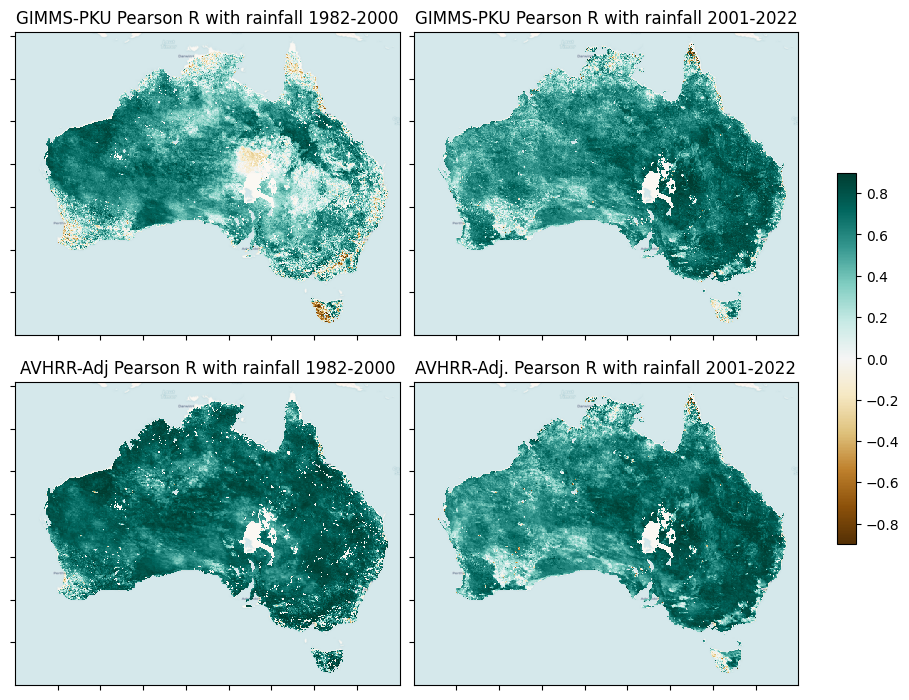

In [109]:
arrs = [corr_before_modis, corr_during_modis,
        corr_before_modis_merge, corr_during_modis_merge
       ]
names = ['GIMMS-PKU Pearson R with rainfall 1982-2000', 'GIMMS-PKU Pearson R with rainfall 2001-2022',
        'AVHRR-Adj Pearson R with rainfall 1982-2000', 'AVHRR-Adj. Pearson R with rainfall 2001-2022'
        ]

fig,ax = plt.subplots(2,2, figsize=(9,7), sharey=True, layout='constrained')
for a,ar,n in zip(ax.ravel(), arrs, names):
    im = ar.plot(vmin=-0.9, vmax=0.9, ax=a, add_labels=False, add_colorbar=False, cmap='BrBG')
    ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_title(n, fontsize=12)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.55, orientation='vertical', label='')

## Compare phenology trends

### Smoothing filters

In [ ]:
merge = merge.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})

In [ ]:
# rolling means
pku_smooth = pku.rolling(time=3, center=True, min_periods=1).mean()
merge_smooth = merge.rolling(time=3, center=True, min_periods=1).mean()

#SG cuts of last 6 months so clip to complete calendar years.
pku_smooth = pku_smooth.sel(time=slice('1982', '2021'))
merge_smooth = merge_smooth.sel(time=slice('1982', '2021'))

# #increase temporal res.
pku_smooth = pku_smooth.resample(time="2W").interpolate("linear")
merge_smooth = merge_smooth.resample(time="2W").interpolate("linear")

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
# pku.mean(['x', 'y']).plot(ax=ax, label='GIMMS PKU NDVI')
pku_smooth.mean(['x', 'y']).plot(ax=ax, label='GIMMS-PKU NDVI rolling mean')
merge_smooth.mean(['x', 'y']).plot(ax=ax, label='AVHRR-Adj. rolling mean')
ax.legend(loc='upper right')
ax.set_title('Smoothing of NDVI');

### Phenology

In [ ]:
import warnings
warnings.simplefilter('ignore')
pku_doy = pku_smooth.groupby('time.year').map(xr_phenology)
merge_doy = merge_smooth.groupby('time.year').map(xr_phenology)

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(11,4))
# ax2 = ax.twinx()
pku_doy.vPOS.mean(['x', 'y']).plot(ax=ax, c='orange', label='vPOS GIMMS-PKU')
merge_doy.vPOS.mean(['x', 'y']).plot(ax=ax, c='blue', label='vPOS AVHRR-Adj.')
# doy.AOS.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
# doy.Trough.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
ax.legend(loc='upper left')
# ax.set_ylim(0.1, 0.22)
ax.set_title('')
# ax2.set_title('Australia-wide trends in Peak-Of-Season NDVI');

### Per pixel trends in POS

Use the Mann-Kendall robust regression (this is quite slow)

In [ ]:
pku_pos_trends = Mann_Kendall_test(pku_doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()
# 
pku_vpos_trends = Mann_Kendall_test(pku_doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

merge_pos_trends = Mann_Kendall_test(merge_doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

merge_vpos_trends = Mann_Kendall_test(merge_doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()



In [ ]:
sb.set(font_scale=1.0)
vmin=1
vmax=300
font=12

fig,ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,4)):
    if i==0:
        im = pku_doy['POS'].where(pku_doy['POS']>20).median('year').plot(cmap='cubehelix_r',  vmin=vmin, vmax=vmax,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('GIMMS-PKU Median POS 1982-2022', fontsize=font)
    
    if i==1:
        t = pku_pos_trends.trend.where((pku_pos_trends.trend>-0.02) | (pku_pos_trends.trend<-0.03))
        im = t.plot(vmin=-3, vmax=3, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(pku_vpos_trends.trend.where(pku_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('GIMMS-PKU Trends in POS 1982-2022', fontsize=font)

    if i==2:
        im = merge_doy['POS'].where(merge_doy['POS']>20).median('year').plot(cmap='cubehelix_r',  vmin=vmin, vmax=vmax,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('AVHRR-Adj. Median POS 1982-2022', fontsize=font)
    
    if i==3:
        t = merge_pos_trends.trend.where((merge_pos_trends.trend>-0.02) | (merge_pos_trends.trend<-0.03))
        im = t.plot(vmin=-3, vmax=3, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(merge_vpos_trends.trend.where(merge_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('AVHRR-Adj. Trends in POS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_compare_PKU_perpixel_trends.png", bbox_inches='tight', dpi=300)

In [ ]:
sb.set(font_scale=1.0)
fig,ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,4)):
    if i==0:
        m = pku_doy['vPOS'].median('year')
        im = m.where(m>0).plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('GIMMS-PKU Median vPOS 1982-2022', fontsize=font)
    
    if i==1:
        im = pku_vpos_trends.trend.where(pku_vpos_trends.trend!=0).plot(vmin=-0.004, vmax=0.004, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(pku_vpos_trends.trend.where(pku_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('GIMMS-PKU Trends in vPOS 1982-2022', fontsize=font)

    if i==2:
        m = merge_doy['vPOS'].median('year')
        im = m.where(m>0).plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('AVHRR-Adj. Median vPOS 1982-2022', fontsize=font)
    
    if i==3:
        im = merge_vpos_trends.trend.where(merge_vpos_trends.trend!=0).plot(vmin=-0.004, vmax=0.004, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(merge_vpos_trends.trend.where(merge_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('AVHRR-Adj. Trends in vPOS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_compare_PKU_perpixel_trends.png", bbox_inches='tight', dpi=300)

### Trends in POS & vPOS etc. disaggregrated by bioclimatic region


In [ ]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

#### The second way

In [ ]:
doy_var = [pku_pos_trends, pku_vpos_trends, merge_pos_trends, merge_vpos_trends]
names = ['PKU_POS', 'PKU_vPOS', 'AVHRR-Adj._POS', 'AVHRR-Adj._vPOS']

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], pku.isel(time=1))
    mask = round_coords(mask)
    
    mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.drop('spatial_ref').to_dataframe()
        doy_df = doy_df[['trend', 'signif']]
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'trend':'trend_'+n,
            'signif':'signif_'+n,
                      }, axis=1)
        inner.append(doy_df)
    outer.append(inner)

trends_df=[]
for i in range(0,len(outer)):
    xx = trends_df.append(pd.concat(outer[i]))
trends_df = pd.concat(trends_df).reset_index(drop=True)

### POS

Landsat

In [ ]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_PKU_POS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-2.5,2.5))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_PKU_POS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_PKU_bioregion_dist_1988_2022.png",
          bbox_inches='tight', dpi=300);

AVHRR-adj.

In [ ]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_AVHRR-Adj._POS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-2.5,2.5))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_AVHRR-Adj._POS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_AVHRR-Adj._bioregion_dist_1988_2022.png",
          bbox_inches='tight', dpi=300);

### vPOS

Landsat

In [ ]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_PKU_vPOS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.005, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_PKU_vPOS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_PKU_bioregion_dist_1988_2022.png",
          bbox_inches='tight', dpi=300);

AVHRR-Adj.

In [ ]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_AVHRR-Adj._vPOS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.005, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_AVHRR-Adj._vPOS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_AVHRR-Adj._bioregion_dist_1988_2022.png",
          bbox_inches='tight', dpi=300);